In [7]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
#Read the climate data
dataTemp0 = pd.read_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\climate\climateNASA.csv')

In [11]:
dataTemp

,location,date,year,tmean_Obs,tmax_Obs,tmin_Obs,tmean_Est,tmax_Est,tmin_Est,rain_Obs,rain_Est,rain_NASA
0,Barrow,01/01/1998,1998,17.50,24.5,10.4,16.00,23.60,8.50,0.0,0.000000,0.00
1,Barrow,02/01/1998,1998,20.30,28.3,12.2,19.40,28.30,10.50,0.0,0.000000,0.00
2,Barrow,03/01/1998,1998,23.80,31.5,16.0,22.40,30.70,14.20,0.0,0.000000,5.40
3,Barrow,04/01/1998,1998,22.90,32.2,13.5,22.20,32.00,12.40,0.0,4.700000,6.10
4,Barrow,05/01/1998,1998,21.80,30.0,13.5,18.40,24.90,11.80,9.4,0.000000,5.80
...,...,...,...,...,...,...,...,...,...,...,...,...
50554,Pergamino,27/12/2019,2019,27.40,33.9,20.9,25.03,29.47,20.59,0.3,0.000000,11.17
50555,Pergamino,28/12/2019,2019,25.20,28.6,21.8,26.92,29.86,23.98,0.0,10.443172,4.83
50556,Pergamino,29/12/2019,2019,26.95,34.0,19.9,29.00,34.63,23.37,128.4,23.432490,3.78
50557,Pergamino,30/12/2019,2019,22.35,23.3,21.4,26.04,28.52,23.56,68.2,32.582698,51.02


In [10]:
dataTemp = dataTemp0.dropna()

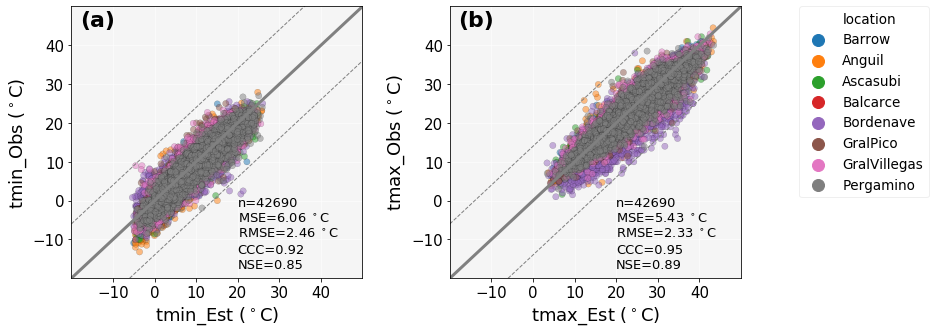

In [12]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
kwargs  =   {'edgecolor':"k"}

fig = plt.figure(figsize=(12,5))

ax=plt.subplot(1, 2, 1)
xmin=-19.99
ymin=-19.99
xmax=49.99
ymax=49.99
per_20=(xmax+abs(xmin))*0.2
plt.plot([xmin,xmax],[ymin,ymax],"-",color="grey", linewidth=3,zorder=2)
plt.plot([xmin+per_20,xmax],[ymin,ymax-per_20],"--",color="grey", linewidth=1,zorder=2)
plt.plot([xmin,xmax],[ymin+per_20,ymax+per_20],"--",color="grey", linewidth=1,zorder=2)
sns.scatterplot(x="tmin_Est", y="tmin_Obs", hue='location', alpha=0.5, data=dataTemp, 
                linewidth=0.2, **kwargs, s=40, zorder=1, markers=filled_markers)

# Formatting graph and background
plt.legend(prop=dict(size=13.5),bbox_to_anchor=(2.5, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('tmin_Obs ($^\circ$C)', fontsize =18)
plt.xlabel('tmin_Est ($^\circ$C)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dataTemp.tmin_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(dataTemp.tmin_Est.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(-18, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.40, ymax*-0.03,'n='+N,fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.11,'MSE='+MSE+' $^\circ$C',fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.19,'RMSE='+RMSE+' $^\circ$C',fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.27,'CCC='+CCC,fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.35,'NSE='+NSE,fontsize=13,color='k')

####################################################################
ax=plt.subplot(1, 2, 2) 
xmin=-19.99
ymin=-19.99
xmax=49.99
ymax=49.99
per_20=(xmax+abs(xmin))*0.2
plt.plot([xmin,xmax],[ymin,ymax],"-",color="grey", linewidth=3,zorder=2)
plt.plot([xmin+per_20,xmax],[ymin,ymax-per_20],"--",color="grey", linewidth=1,zorder=2)
plt.plot([xmin,xmax],[ymin+per_20,ymax+per_20],"--",color="grey", linewidth=1,zorder=2)
sns.scatterplot(x="tmax_Est", y="tmax_Obs",hue='location', alpha=0.5, data=dataTemp,
                linewidth=0.2, **kwargs, s=40, zorder=1, markers=filled_markers)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(2.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('tmax_Obs ($^\circ$C)', fontsize =18)
plt.xlabel('tmax_Est ($^\circ$C)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(dataTemp.tmax_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(dataTemp.tmax_Est.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(-18, ymax*0.9,'(b)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.40, ymax*-0.03,'n='+N,fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.11,'MSE='+MSE+' $^\circ$C',fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.19,'RMSE='+RMSE+' $^\circ$C',fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.27,'CCC='+CCC,fontsize=13,color='k')
plt.text(xmax*0.40, ymax*-0.35,'NSE='+NSE,fontsize=13,color='k')

####################################################################
plt.subplots_adjust(wspace=0.3, hspace=0.25)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\nasa.png', dpi=300,bbox_inches='tight')